In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for computing PSNR

In [5]:
def compute_psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

IRLS Algorithm
--------------
Define the problem parameters


In [6]:
A = np.array([[1, 3], [3, 1]]) # low dimensions to plot it, you can test larger sizes
b = np.array([-1, 2])

lmbda = 0.5


The function to be minimized is $\frac{1}{2}\|Ax-b\|_2^2 + \lambda \|x\|_1$

In [7]:
f = lambda x: 0.5 * np.sum((A @ x - b) ** 2) + lmbda * np.sum(np.abs(x))

# derivative of f from matrix calculus
df = lambda x: A.T @ (A @ x) - A.T @ b


Plot the function

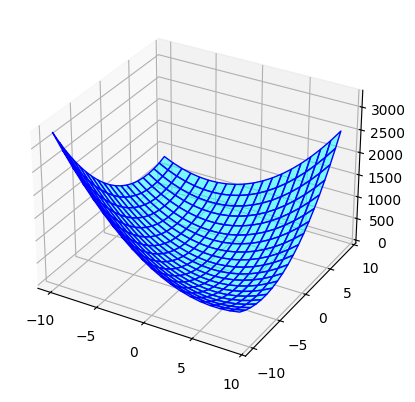

In [8]:
# this function has been prepared only for the visualization sake, no need to go through this but it renders some nice
# graphics :)
F = lambda r1, r2: (r1 * A[0, 0] + r2 * A[0, 1] - b[0]) ** 2 + (r1 * A[1, 0] + r2 * A[1,1] - b[1]) ** 2 + lmbda * (np.abs(r1) + np.abs(r2))
xx, yy = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])

Set the parameters

In [9]:
MAX_ITER = 1e3
TOL_DIST_X = 1e-10

Initialization: test different inizializations, the function is convex, you always converge to the same solution

In [10]:
x0 = np.array([5, -10])

# initialization
all_x = [x0]
distanceX = 1e10  # stopping criteria
cnt = 0
delta = 1e-6

Main loop

In [11]:
while cnt < MAX_ITER and distanceX > TOL_DIST_X:
    x = all_x[-1]

    # compute the weight matrix
    W = np.diag(1 / (np.abs(x) + delta))

    # solve the weighted regularized LS system
    x_current = np.linalg.solve((A.T @ A) + (lmbda*W), (A.T @ b))

    distanceX = np.linalg.norm(x - x_current)

    # store the estimate
    # update all_x
    all_x.append(x_current)

    cnt = cnt + 1

Plot all the estimates

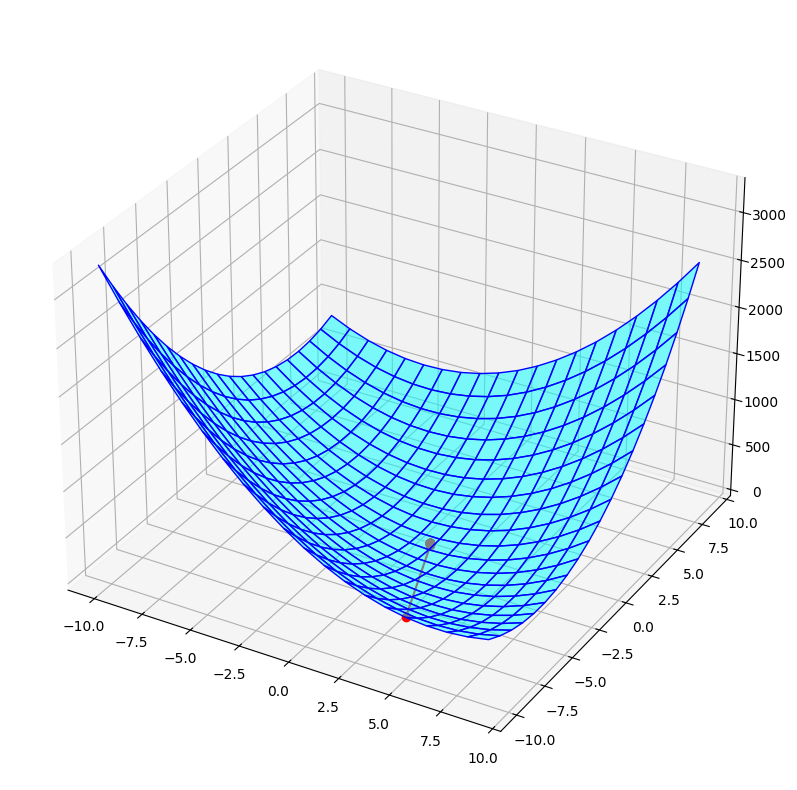

In [12]:
# plot the new estimate
xxplot = [x[0] for x in all_x]
yyplot = [x[1] for x in all_x]
zzplot = F(np.array(xxplot), np.array(yyplot))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])
ax.plot3D(xxplot, yyplot, zzplot, 'r-o')

In [13]:
print(f'nr of iteration of IRLS (before stopping criteria met): {cnt}\n')
print(f'Solution of IRLS: [{x_current[0]:.4f}, {x_current[1]:.4f}]\n')
print(f'Value of the functional: {f(x_current):.4f}\n')


nr of iteration of IRLS (before stopping criteria met): 14

Solution of IRLS: [0.7500, -0.5000]

Value of the functional: 0.6875



**THIS WAS NOT PRESENTED IN THE 2025 EDITION**: MOD dictionary learning
-----------------------
Useful function for plot the 2D DCT dictionary

In [14]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function to perform the sparse coding using your favorite algorithm (IRLS, FISTA or ISTA)

In [15]:
def IRLS(s, D, lmbda, x0=None):
  if x0 is None:
    x0 = np.zeros(D.shape[1])
  delta = 1e-6
  max_iter = 20
  distanceX = 1e10
  toll_x = 1e-3

  x = x0
  cnt = 0
  while cnt < max_iter or distanceX > toll_x:
    W = np.diag(1 / (np.abs(x) + delta))
    x_current = np.linalg.solve((lmbda*W) + (D.T @ D)  , (D.T @ s))
    distanceX = np.linalg.norm(x_current - x, ord=2)
    x = x_current
    cnt = cnt + 1
  return x

Load the image and rescale it in [0,1]

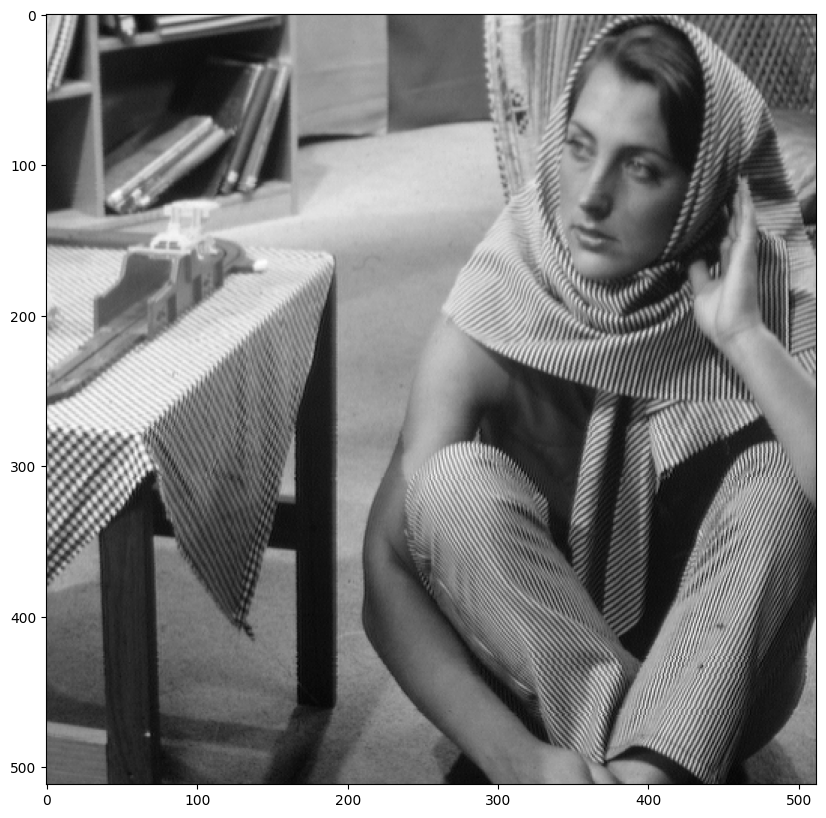

In [16]:
img = imread(f'{rootfolder}/data/barbara.png') / 255
imsz = img.shape
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

Set the parameters

In [17]:
# patch size
p = 8

# number of elements in the patchfrom skimage.io import imread
M = p ** 2

# number of columns in the dictionary
N = 96

# extract the random patches from the noisy image
npatch = 1000

# only few MOD iterations are needed for a good dictionary
max_iter = 10

lmbda = 0.1

Extract $npatch$ random patches from the image


In [18]:
S = np.zeros((M, npatch))
for i in range(npatch):
  coord_x = np.random.randint(0, imsz[0] - p)
  coord_y = np.random.randint(0, imsz[1] - p)
  patch = img[coord_x: coord_x + p, coord_y: coord_y + p]
  S[:, i] = patch.flatten()

In [19]:
# Normalization of the patches
S = S - np.mean(S, axis=1, keepdims=True)

Initialize the dictionary randomly and the normalize the columns

In [20]:
D = np.random.rand(M, N)
# normalization of each column of D
D -= D.mean(axis=0)
D /= np.linalg.norm(D, axis=0, ord=2)

Initialize a matrix for the coefficients of all the patches

In [21]:
X = D.T @ S

Main loop

In [22]:
for iter in range(max_iter):

    # perform the sparse coding for all the patches in S
    for n in range(npatch):
        s = S[:, n]
        x = IRLS(s, D, lmbda)
        X[:, n] = x

    # MOD update
    D = D - np.matmul((lmbda * (np.matmul(D,X) - S)), X.T)

    # normalize the column
    D /= np.linalg.norm(D, axis=0, ord=2)


Show the dictionary

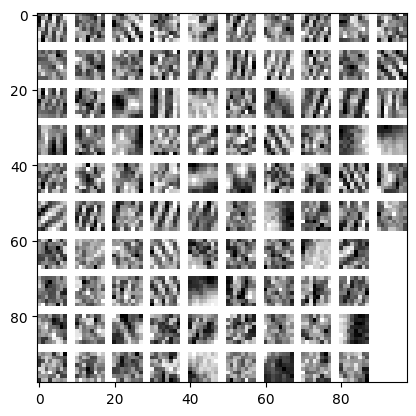

In [23]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')


Denoising via $\ell^1$ sparse coding (use a dictionary learned by KSVD)
------------------------------------
Set the noise level and add the noise to the original image

In [24]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise


Compue the psnr of the noisy input

In [25]:
psnr_noisy = compute_psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

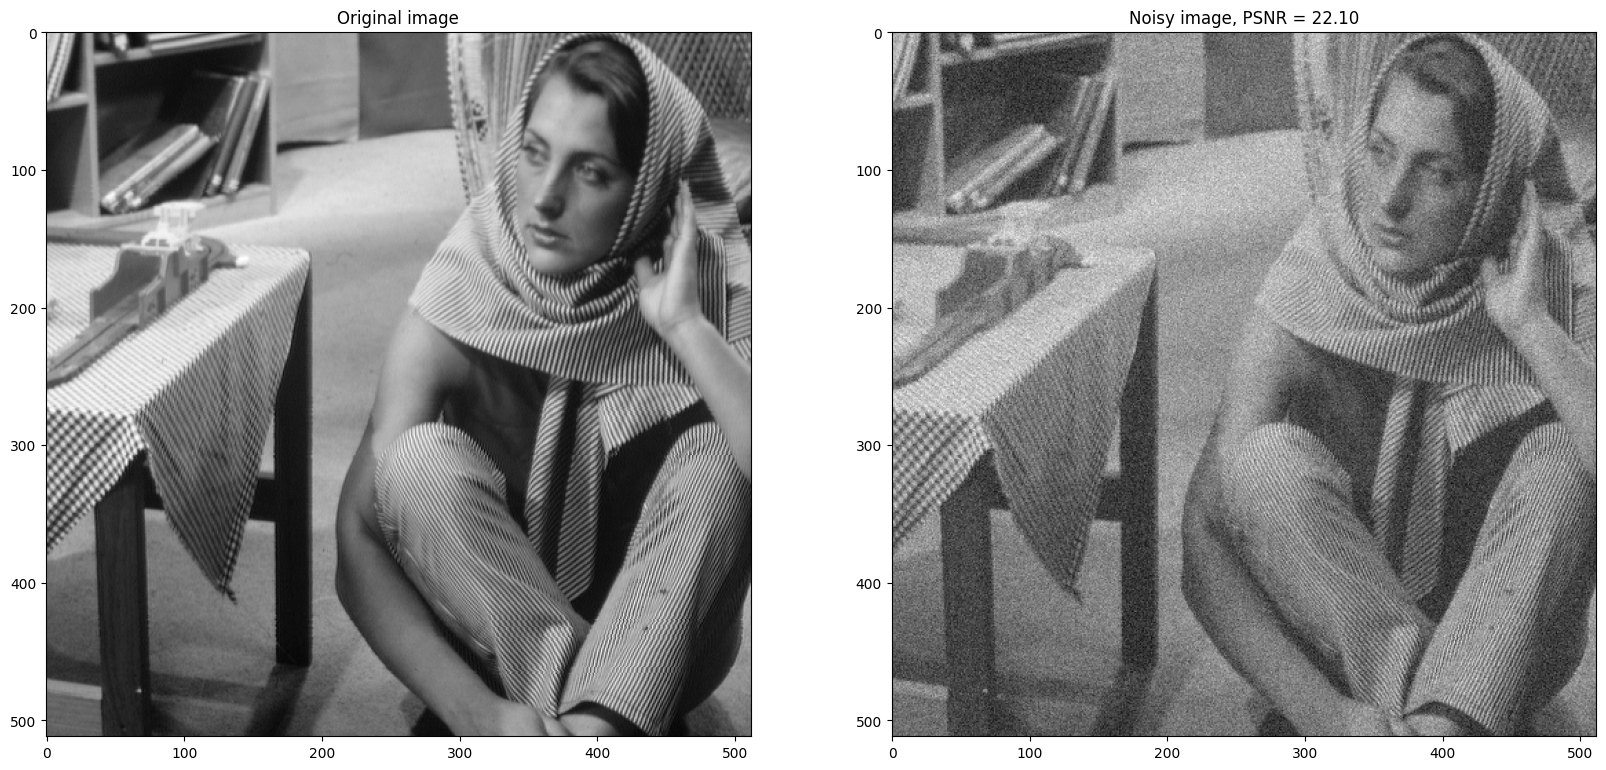

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Use the dictionary computed with the MOD or load a pretrained dictionary $D$

In [29]:
def extract_random_patches(npatch, M, p, img):
  height, width = img.shape
  patches = np.zeros((M, npatch))

  for i in range(npatch):
    start_row = np.random.randint(0, height -p +1)
    start_col = np.random.randint(0, width - p+1)
    patch = img[start_row:start_row+p, start_col:start_col+p].reshape((M,))
    patches[:, i] = patch

  return patches

In [30]:
def remove_mean(S, normalize=False):
  num_rows ,num_cols = S.shape
  new_S = np.zeros_like(S)

  for i in range(num_cols):
    column_i = S[:,i]
    mean_column_i  = np.mean(column_i)
    new_S_column_i = column_i - mean_column_i
    if normalize == True:
      new_S_column_i = new_S_column_i/np.linalg.norm(new_S_column_i)
    new_S[: , i] = new_S_column_i

  return new_S

In [33]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x_OMP = np.zeros(N)
  # Support set
  omega = []
  # residual
  r = s

  # STOPPING CRITERIA
  while np.count_nonzero(x_OMP) < L and np.linalg.norm(r, 2) > tau:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (np.dot(r.T, dj)/np.linalg.norm(dj)**2)**2

    # find the column of D that matches at best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    D_omega_T_D_omega = np.dot(D_omega.T, D_omega)
    x_OMP[omega] = np.dot(np.linalg.inv(D_omega_T_D_omega), np.dot(D_omega.T, s))

    # update the residual
    r = s - np.dot(D_omega, x_OMP[omega])

  return x_OMP

In [27]:
def ksvd(S, M, N, max_iter, npatch, L, print_time=False):

    # intialize the dictionary
    D = np.random.randn(M, N)

    # normalize each column of D (zero mean and unit norm)
    # UPDATE D
    D = remove_mean(D, normalize=True)

    # initialize the coefficient matrix
    X = np.zeros((N, npatch))

    # Main KSVD loop
    for iter in range(max_iter):
        time_start = time.time()
        print(f'iter {iter}')

        # Sparse coding step
        # perform the sparse coding via OMP of all the columns of S
        for n in range(npatch):
            X[:, n] = OMP(S[:, n], D, L, 0)

        # Dictionary update step
        # iterate over the columns of D
        for j in range(N):
            # find which signals uses the j-th atom in the sparse coding
            omega = np.where(X[j, :] != 0)[0]

            if len(omega) == 0:
                # if the atom is never used then ignore or substitute it with a random vector
                D[:, j] = np.random.randn(M)
                D[:, j] = remove_mean(D[:, j], normalize=True)
            else:
                # compute the residual matrix E, ignoring the j-th atom
                not_j = list(set(range(N))- {j})
                E = S - np.dot(D[:, not_j], X[not_j, :])

                # restrict E to the columns indicated by omega
                Eomega = E[:, omega]

                # Compute the best rank-1 approximation
                U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)
                truncated_U = U[:, 0]
                truncated_V = V[0, :]
                truncated_Sigma = Sigma[0]

                # update the dictionary
                D[:, j] = truncated_U

                # update the coefficient matrix
                X[j, omega] = truncated_Sigma * truncated_V

        time_end = time.time()
        if print_time:
            print(f'Iteration {iter} runtime: {time_end-time_start}')

    return D

Learn the dictionary from the clean image

In [38]:
# Extract random patches
npatch = 10000

# maximum number of nonzero coefficients for the sparse coding
L = 4

S_clean = extract_random_patches(npatch, M, p, img)

# Remove the mean
S_clean = S_clean - np.mean(S_clean, axis=0, keepdims=True)

# Learn the dictionary
D_clean = ksvd(S_clean, M, N, max_iter, npatch, L, print_time=True)

iter 0
Iteration 0 runtime: 31.2667715549469
iter 1
Iteration 1 runtime: 30.087268352508545
iter 2
Iteration 2 runtime: 30.19888710975647
iter 3
Iteration 3 runtime: 30.12662982940674
iter 4
Iteration 4 runtime: 32.584999084472656
iter 5
Iteration 5 runtime: 30.857706785202026
iter 6
Iteration 6 runtime: 30.833127737045288
iter 7
Iteration 7 runtime: 30.199138402938843
iter 8
Iteration 8 runtime: 30.374793529510498
iter 9
Iteration 9 runtime: 32.641783714294434


In [ ]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# show the dictionary
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

In [36]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 2.2
lmbda = tau * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [39]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i: i + p, j: j + p]
        s_mean = np.mean(s)

        # store and subtract the mean
        s = s - s_mean
        s = s.reshape(-1)

        # perform the sparse coding of the patch s to compute the coefficients vector x
        x = IRLS(s, D_clean, lmbda)

        # perform the reconstruction
        s_hat = D_clean @ x

        w = 1

        # add back the mean
        s_hat = s_hat + s_mean


        # put the denoised patch into the estimated image using uniform weights
        # update img_hat
        img_hat[i: i + p, j: j + p] = img_hat[i: i + p, j: j + p] + w * s_hat.reshape(p, p)

        # store the weight of the current patch in the weight matrix
        # update weights
        weights[i: i + p, j: j + p] = weights[i: i + p, j: j + p] + w

Normalize the estimated image with the computed weights

In [40]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.69')

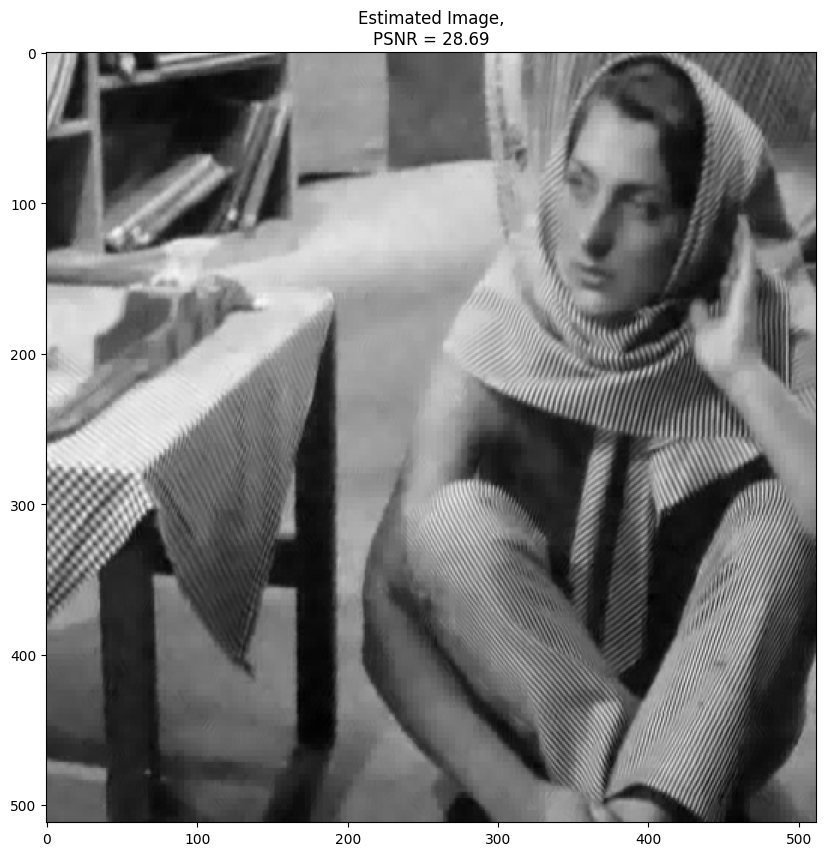

In [41]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
